In [1]:
# SPDX-License-Identifier: Apache-2.0 AND CC-BY-NC-4.0
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Quantum Enhanced Optimization for Radar and Communications Applications 


The Low Autocorrelation Binary Sequences (LABS) is an important and challenging optimization problem with applications related to radar, telecommunications, and other signal related applications. This CUDA-Q Academic module will focus on a clever quantum-enhanced hybrid method developed in a collaboration between Kipu Quantum, University of the Basque Country EHU, and NVIDIA for solving the LABS problem. (This notebook was jointly developed with input from all collaborators.)

Other CUDA-Q Academic modules like [Divide and Conquer MaxCut QAOA](https://github.com/NVIDIA/cuda-q-academic/tree/main/qaoa-for-max-cut) and [Quantum Finance](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb), demonstrate how quantum computing can be used outright to solve optimization problems. This notebook demonstrates a slightly different approach. Rather than considering QPUs as the tool to produce the final answer, it demonstrates how quantum can be used to enhance the effectiveness of leading classical methods.  

The benefits of such an approach were highlighted in [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1).  This notebook, co-created with the authors of the paper, will allow you to explore the findings of their research and write your own CUDA-Q code that builds a representative quantum-enhanced workflow for solving the LABS problem. Moreover, it will introduce advancements in counteradiabatic optimization techniques on which reduce the quantum resources required to run on a QPU.

**Prerequisites:** This lab assumes you have a basic knowledge of quantum computing, including operators, gates, etc.  For a refresher on some of these topics, explore the [Quick start to Quantum](https://github.com/NVIDIA/cuda-q-academic/tree/main/quick-start-to-quantum) series.

**In this lab you will:**
* 1. Understand the LABS problem and its relation ot radar and communication applications.
* 2. Solve LABS classically with memetic tabu search and learn about the limitations of such methods.
* 3. Code a couteradiabatic algorithm using CUDA-Q to produce approximate solutions to the LABS problem.
* 4. Use the CUDA-Q results to seed your tabu search and understand the potential benefits of this approach.


**Terminology you will use:**
* Low autocorrelation of binary sequences (LABS)
* counteradiabatic optimization
* memetic-tabu search

**CUDA-Q Syntax you will use:**
* cudaq.sample()
* @cudaq.kernel
* ry(), rx(), rz(), x(), h() 
* x.ctrl()

Run the code below to initialize the libraries you will need.

In [2]:
import cudaq
import numpy as np
from math import floor
import auxiliary_files.labs_utils as utils

## The LABS problem and applications

The **Low Autocorrelation Binary Sequences (LABS)** problem is fundamental to many applications, but originated with applications to radar. 

Consider a radar that monitors airport traffic.  The radar signal sent to detect incoming planes must have as much range as possible to ensure safe approaches are planned well in advance.  The range of a radar signal can be increased by sending a longer pulse.  However, in order to differentiate between multiple objects, pulses need to be short to provide high resolution. So, how do you handle situations where you need both?

One solution is a technique called pulse compression.  The idea is to send a long signal, but vary the phase at regular intervals such that the resolution is increased. Generally, the initial signal will encode a binary sequence of phase shifts, where each interval corresponds to a signal with a 0 or 180 degree phase shift. 

The tricky part is selecting an optimal encoding sequence.  When the signal returns, it is fed into a matched filter with the hope that a singular sharp peak will appear, indicating clear detection.  The autocorrelation of the original signal, or how similar the signal is to itself,  determines if a single peak or a messier signal with sidelobes will be detected. A signal should have high autocorrelation when overlayed on top of itself, but low autocorrelation when shifted with a lag. 

Consider the image below.  The signal on the left has a crisp single peak while the single on the right produces many undesirable sidelobes which can inhibit clear detection.  

<img src="images/quantum_enhanced_optimization_LABS/radar.png" width="800">


So, how do you select a good signal?   This is where LABS comes in, defining these questions as a binary optimization problem. Given a binary sequence of length $N$, $(s_1 \cdots s_N) \in {\pm 1}^N$, the goal is to minimize the following objective function.

$$ E(s) = \sum_{k=1}^{N-1} C_k^2 $$

Where $C_k$ is defined as. 

 $$C_k= \sum_{i=1}^{N-k} s_is_{i+k}$$


So, each $C_k$ computes how similar the original signal is to the shifted one for each offset value $k$.  To explore this more, try the interactive widget linked [here](https://nvidia.github.io/cuda-q-academic/interactive_widgets/labs_visualization.html).  See if you can select a very good and very poor sequence and see the difference for the case of $N=7$.

## Classical Solution of the LABS problem

The LABS problem is tricky to solve for a few reasons. First, the configuration space grows exponentially.  Second, underlying symmetries of the problem result in many degeneracies in the optimization landscape severely inhibiting local search methods. 

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 1:</h3>
    <p style="font-size: 16px; color: #333;">
Using the widget above, try to find some of the symmetries for the LABS problem. That is, for a fixed bitstring length, can you find patterns to produce the same energy with different pulse patterns. 
</div>

The best known performance for a classical optimization technique is Memetic Tabu search (MTS) which exhibits a scaling of $O(1.34^N)$.  The MTS algorithm is depicted below.  It begins with a randomly selected population of bitstrings and finds the best solution from them.  Then, a child is selected by sampling directly from or combining multiple bitstrings from the population.  The child is mutated with probability $p_{mutate}$ and then input to a tabu search, which performs a modified greedy local search starting from the child bitstring.  If the result is better than the best in the population, it is updated as the new leader and randomly replaces a  bitstring in the population.


<img src="images/quantum_enhanced_optimization_LABS/mts_algorithm.png" width="500">

Such an approach is fast, parallelizable, and allows for exploration with improved searching of the solution landscape.  

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 2:</h3>
    <p style="font-size: 16px; color: #333;">
Before exploring any quantum approach, get a sense for how MTS works by coding it yourself based generally on the figure above. Algorithms for the combine and mutate steps are provided below as used in the paper. You may need to research more specific details of the process, especially for how tabu search is performed. The MTS procedure should output and optimal bitstring and its energy.  Also, write a function to visualize the results including the energy distribution of the final population.
</div>



<img src="images/quantum_enhanced_optimization_LABS/combine_mutate.png" width="400">



Best energy: 34
Best bitstring: [-1, 1, -1, -1, 1, -1, 1, -1, -1, -1, 1, -1, -1, -1, 1, 1, 1, 1, 1, -1]


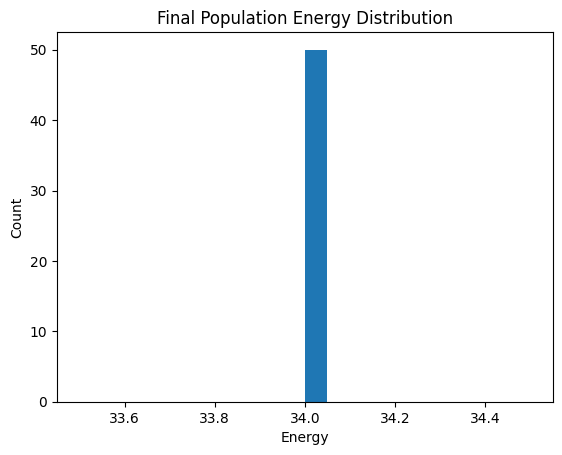

In [3]:
#TODO - Write code to perform MTS
# Import Python's random module for randomness in selection, mutation, and initialization
import random

# Import math utilities (not strictly required here but often useful in optimization)
import math

# Import deque for efficiently maintaining a fixed length tabu list
from collections import deque

# Import NumPy for numerical operations and seeding consistency
import numpy as np

# Import matplotlib for plotting energy distributions
import matplotlib.pyplot as plt


# -----------------------------
# LABS energy function
# -----------------------------

# Define the LABS energy function which scores a bitstring
def labs_energy(bits):
    # Get the length of the sequence
    n = len(bits)

    # Initialize total energy to zero
    E = 0

    # Loop over all possible shifts k
    for k in range(1, n):

        # Initialize the autocorrelation value for this shift
        ck = 0

        # Compute the autocorrelation for shift k
        for i in range(n - k):
            ck += bits[i] * bits[i + k]

        # Add the squared autocorrelation to the energy
        E += ck * ck

    # Return the total LABS energy
    return E


# -----------------------------
# Helper functions
# -----------------------------

# Generate a random bitstring of length n with values +1 or -1
def random_bitstring(n):
    return [1 if random.random() < 0.5 else -1 for _ in range(n)]


# Combine two parent bitstrings to create a child
def combine(parent_a, parent_b, method="uniform"):
    # Determine the length of the parents
    n = len(parent_a)

    # If using one point crossover
    if method == "one_point":
        # Randomly choose a cut location
        cut = random.randint(1, n - 1)

        # Take the first part from parent A and second from parent B
        return parent_a[:cut] + parent_b[cut:]

    # Otherwise use uniform crossover
    else:
        # Create an empty child list
        child = []

        # For each position in the bitstring
        for i in range(n):
            # Randomly choose the bit from one of the parents
            child.append(parent_a[i] if random.random() < 0.5 else parent_b[i])

        # Return the combined child
        return child


# Mutate a bitstring by flipping bits with probability p_mutate
def mutate(bits, p_mutate=0.02):
    # Copy the input bitstring so the original is not modified
    out = bits[:]

    # Loop through every bit
    for i in range(len(out)):
        # With probability p_mutate, flip the bit
        if random.random() < p_mutate:
            out[i] *= -1

    # Return the mutated bitstring
    return out


# -----------------------------
# Tabu Search
# -----------------------------

# Perform tabu search starting from a given bitstring
def tabu_search(
    start_bits,
    max_iters=800,
    tabu_tenure=30,
    aspiration=True,
):
    # Store the length of the bitstring
    n = len(start_bits)

    # Set the current solution to the starting point
    current = start_bits[:]

    # Compute the energy of the current solution
    current_E = labs_energy(current)

    # Initialize the best solution found so far
    best = current[:]
    best_E = current_E

    # Create a tabu list with fixed maximum length
    tabu = deque(maxlen=tabu_tenure)

    # Create a set version of the tabu list for fast lookup
    tabu_set = set()

    # Repeat the tabu search process for a fixed number of iterations
    for _ in range(max_iters):

        # Track the best move in the current neighborhood
        best_move = None
        best_candidate = None
        best_candidate_E = None

        # Explore all single bit flip neighbors
        for idx in range(n):
            # Create a candidate by flipping one bit
            candidate = current[:]
            candidate[idx] *= -1

            # Compute its energy
            cand_E = labs_energy(candidate)

            # Check if this move is tabu
            is_tabu = idx in tabu_set

            # Allow tabu moves if they improve the global best solution
            if is_tabu and aspiration and cand_E < best_E:
                is_tabu = False

            # Skip tabu moves that do not satisfy aspiration
            if is_tabu:
                continue

            # Keep the best candidate found
            if best_candidate_E is None or cand_E < best_candidate_E:
                best_candidate_E = cand_E
                best_candidate = candidate
                best_move = idx

        # If no valid move exists, stop early
        if best_candidate is None:
            break

        # Move to the best candidate
        current = best_candidate
        current_E = best_candidate_E

        # Add the move to the tabu list
        tabu.append(best_move)

        # Rebuild the tabu set for consistency
        tabu_set = set(tabu)

        # Update the best solution found
        if current_E < best_E:
            best_E = current_E
            best = current[:]

    # Return the best solution and its energy
    return best, best_E


# -----------------------------
# Memetic Tabu Search main loop
# -----------------------------

def mts_labs(
    n,
    pop_size=40,
    generations=300,
    p_mutate=0.02,
    tabu_iters=600,
    tabu_tenure=30,
    elite_keep=2,
    tournament_k=3,
    seed=None,
):
    # Set random seeds for reproducibility if provided
    if seed is not None:
        random.seed(seed)
        np.random.seed(seed)

    # Initialize a random population
    population = [random_bitstring(n) for _ in range(pop_size)]

    # Compute energies for all population members
    energies = [labs_energy(x) for x in population]

    # Sort population by energy
    def sort_pop():
        nonlocal population, energies
        order = sorted(range(pop_size), key=lambda i: energies[i])
        population = [population[i] for i in order]
        energies = [energies[i] for i in order]

    # Tournament selection for parent selection
    def tournament_select():
        candidates = random.sample(range(pop_size), tournament_k)
        best_idx = min(candidates, key=lambda i: energies[i])
        return population[best_idx]

    # Sort population initially
    sort_pop()

    # Track global best solution
    global_best = population[0][:]
    global_best_E = energies[0]

    # Main evolutionary loop
    for _ in range(generations):
        # Select two parents
        p1 = tournament_select()
        p2 = tournament_select()

        # Combine parents into a child
        child = combine(p1, p2)

        # Mutate the child
        child = mutate(child, p_mutate=p_mutate)

        # Improve child using tabu search
        child, child_E = tabu_search(
            child,
            max_iters=tabu_iters,
            tabu_tenure=tabu_tenure,
        )

        # Update global best if improved
        if child_E < global_best_E:
            global_best_E = child_E
            global_best = child[:]

        # Sort population by energy
        sort_pop()

        # Replace the worst individual
        population[-1] = child
        energies[-1] = child_E

    # Final sorting before returning
    sort_pop()

    # Return all relevant results
    return {
        "best_bits": global_best,
        "best_energy": global_best_E,
        "final_population": population,
        "final_energies": energies,
    }


# -----------------------------
# Visualization
# -----------------------------

# Plot a histogram of final population energies
def plot_energy_distribution(energies):
    plt.figure()
    plt.hist(energies, bins=20)
    plt.xlabel("Energy")
    plt.ylabel("Count")
    plt.title("Final Population Energy Distribution")
    plt.show()


# -----------------------------
# Example usage
# -----------------------------

# Only run this block if the file is executed directly
if __name__ == "__main__":
    # Define problem size
    N = 20

    # Run MTS on LABS
    result = mts_labs(
        n=N,
        pop_size=50,
        generations=250,
        p_mutate=0.03,
        tabu_iters=700,
        tabu_tenure=35,
        seed=7,
    )

    # Print the best energy found
    print("Best energy:", result["best_energy"])

    # Print the corresponding bitstring
    print("Best bitstring:", result["best_bits"])

    # Plot the final population energy distribution
    plot_energy_distribution(result["final_energies"])

import random
import itertools

# 1) Basic format checks: bitstrings must only contain +1 and -1
def assert_is_pm1(bits):
    assert all(b in (-1, 1) for b in bits), "Bitstring contains values not in {+1, -1}."


# 2) Brute force solver for tiny N so you know the true minimum energy
def brute_force_best_energy(N, labs_energy_fn):
    best_E = None
    best_bits = None
    for bits01 in itertools.product([1, -1], repeat=N):
        bits = list(bits01)
        E = labs_energy_fn(bits)
        if best_E is None or E < best_E:
            best_E = E
            best_bits = bits
    return best_bits, best_E


def sanity_checks_ex2(labs_energy_fn, mutate_fn, combine_fn, tabu_search_fn, mts_fn):
    # Pick a tiny size where brute force is easy
    N = 6

    # Build a random example bitstring
    x = [1 if random.random() < 0.5 else -1 for _ in range(N)]

    # Check bitstring format
    assert_is_pm1(x)

    # 2A) Energy must be a non negative integer
    E = labs_energy_fn(x)
    assert isinstance(E, (int, float)), "Energy should be numeric."
    assert E >= 0, "Energy should never be negative."
    assert abs(E - round(E)) < 1e-9, "Energy should be an integer for LABS."

    # 2B) Symmetry checks: flip all signs and reverse should not change energy
    x_flip = [-b for b in x]
    x_rev = list(reversed(x))
    assert labs_energy_fn(x) == labs_energy_fn(x_flip), "Energy should be invariant under global sign flip."
    assert labs_energy_fn(x) == labs_energy_fn(x_rev), "Energy should be invariant under sequence reversal."

    # 2C) Mutation should preserve pm1 format
    xm = mutate_fn(x, p_mutate=0.5)
    assert_is_pm1(xm)

    # 2D) Combine should preserve pm1 format and length
    y = [1 if random.random() < 0.5 else -1 for _ in range(N)]
    child = combine_fn(x, y)
    assert len(child) == N, "Child length must match parents."
    assert_is_pm1(child)

    # 2E) Tabu search should not return a worse solution than it started with
    best_bits, best_E = tabu_search_fn(x, max_iters=200, tabu_tenure=15)
    assert_is_pm1(best_bits)
    assert best_E <= labs_energy_fn(x), "Tabu search should not worsen the starting energy."

    # 2F) MTS should beat random on average, at least for small N
    # Compare MTS best energy to the best energy found in a random sample of the same size
    mts_result = mts_fn(n=N, pop_size=30, generations=60, tabu_iters=150, tabu_tenure=15, seed=1)
    mts_best_E = mts_result["best_energy"]

    random_pop = [[1 if random.random() < 0.5 else -1 for _ in range(N)] for _ in range(30)]
    random_best_E = min(labs_energy_fn(b) for b in random_pop)

    assert mts_best_E <= random_best_E, "MTS should usually beat a same size random population for tiny N."

    # 2G) For tiny N, MTS should sometimes reach the true optimum
    # This is not guaranteed every run, so treat it as a goal check not a strict requirement
    true_bits, true_E = brute_force_best_energy(N, labs_energy_fn)
    print("Brute force optimum energy for N =", N, "is", true_E)
    print("MTS best energy for N =", N, "is", mts_best_E)

    return True

## Building a Quantum Enhanced Workflow

Despite the effectiveness of MTS, it still exhibits exponential scaling  $O(1.34^N)$ behavior and becomes intractable for large $N$.  Quantum computing provides a potential alternative method for solving the LABS problem because the properties of entanglement, interference, and superpositon may allow for a better global search.  Recent demonstrations have even produced evidence that the quantum approximate optimization algorithm (QAOA) can be used to reduce the scaling of the LABS problem to $O(1.21^N)$ for $N$ between 28 and 40 with quantum minimum finding.

However, current quantum hardware limitations restrict solution to problems of greater than about $N=20$, meaning that it will be some time before quantum approaches can outperform the classical state of the art. It should also be noted that standard QAOA can struggle with LABS and require many layers to converge the parameters if other tricks are not employed.

The authors of [Scaling advantage with quantum-enhanced memetic tabu search for LABS](https://arxiv.org/html/2511.04553v1) cleverly explored an alternate path that combines quantum and classical approaches and might be able to provide a more near-term benefit.  Instead of expecting the quantum computer to solve the problem entirely, they asked how a quantum approach might enhance MTS.

The basic idea is that a quantum optimization routine could run first and the resulting state be sampled to produce a better population for MTS. Many such heuristics for defining the initial population are possible, but the rest of this notebook will explore their methodology, help you to build the workflow yourself, and allow you to analyze the benefits of their approach.

The first step of quantum enhanced MTS (QE-MTS) is to prepare a circuit with CUDA-Q that approximates the ground state of the Hamiltonian corresponding to the LABS problem. You could do this with any optimization algorithm such as QAOA or using an adiabatic approach.  (See the [Quantum Portfolio Optimization](https://github.com/NVIDIA/cuda-q-academic/blob/main/quantum-applications-to-finance/03_qchop.ipynb) CUDA-Q Academic lab for a detailed comparison of these two common approaches.)

The authors of this work opted for an adiabatic approach (More on why later). Recall that the goal of an adiabatic optimization is to begin with a Hamiltonian that has an easily prepared ground state ($H_i$). Then, the adiabatic Hamiltonian $H_{ad}$ can be constructed as $H_{ad}(\lambda) = (1-\lambda)H_i +\lambda H_f $, where $\lambda$ is a function of time and $H_f$ is the Hamiltonian representing a qubit encoding of the LABS problem. 

$$H_f = 2 \sum_{i=1}^{N-2} \sigma_i^z \sum_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} \sigma_{i+k}^z 
+ 4 \sum_{i=1}^{N-3} \sigma_i^z \sum_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \sum_{k=t+1}^{N-i-t} \sigma_{i+t}^z \sigma_{i+k}^z \sigma_{i+k+t}^z$$

The authors also selected $H_i = \sum_i h^x_i \sigma^x_i $ which has an easily prepared ground state of $\ket{+}^{\otimes N}$.

The challenge for implementing the optimization procedure becomes selection of an operator that will quickly and accurately evolve to the ground state of $H_f$.  One approach is to use a so-called auxiliary countradiabatic (CD) term $H_{CD}$, which corrects diabatic transitions that jump out of the ground state during the evolution. The figure below demonstrates the benefit of using a CD correction.


<img src="images/quantum_enhanced_optimization_LABS/counteradiabatic.png" width="900">




An operator called the adiabatic gauge potential $A_{\lambda}$ is the ideal choice for the CD term as it suppresses all possible diabatic transitions, resulting in the following total system to evolve.

$$ H(\lambda) = H_{ad}(\lambda) + \lambda H_{CD} (\lambda) $$

$A(\lambda)$ is derrived from $H_{ad}(\lambda)$  (see paper for details) as it contains information about underlying physics of the problem. 

There is a problem though.  The $A(\lambda)$ term cannot be efficiently expressed exactly and needs to be approximated.  It also turns out that in the so called impulse regime, where the adiabatic evolution is very fast, $H_{cd} (\lambda)$ dominates $H_{ad}(\lambda)$, meaning that the final implementation corresponds to the operator $H(\lambda) = H^1_{cd}(\lambda)$ where  $H^1_{cd}(\lambda)$ is a first order approximation of $A(\lambda)$ (see equation 7 in the paper).

A final step is to use Trotterization to define the quantum circuit to apply $e^{-\theta (t) i H_{cd}}$. The details for this derivation are shown in the appendix of the paper. and result from equation B3 is shown below.  

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

It turns out that this implementation is more efficient than QAOA in terms of gate count. The authors calculated that for $N=67$, QAOA would require 1.4 million entangling gates while the CD approach derived here requires only 236 thousand entangling gates.


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 3:</h3>
    <p style="font-size: 16px; color: #333;">
At first glance, this equation might looks quite complicated. However, observe the structure and note two "blocks" of terms.  Can you spot them?  

They are 2 qubit terms that look like $R_{YZ}(\theta)$ or $R_{ZY}(\theta)$.

As well as 4 qubit terms that look like $R_{YZZZ}(\theta)$, $R_{ZYZZ}(\theta)$, $R_{ZZYZ}(\theta)$, or $R_{ZZZY}(\theta)$.

Thankfully the authors derive a pair of circuit implementations for the two and four qubit terms respectively, shown in the figures below.

Using CUDA-Q, write a kernel for each which will be used later to construct the full implementation.

* Hint: Remember that the adjoint of a rotation gate is the same as rotating in the opposite direction. 

* Hint: You may also want to define a CUDA-Q kernel for an R$_{ZZ}$ gate.

* Hint: Implementing a circuit from a paper is a great place where AI can help accelerate your work.  If you have access to a coding assistant, feel free to use it here.
</div>

<img src="images/quantum_enhanced_optimization_LABS/kernels.png" width="1300">


In [4]:
# TODO  Write CUDA-Q kernels to apply the 2 and 4 qubit operators. 
# Import cudaq so we can write CUDA Q kernels and quantum gates
import cudaq

# Import numpy only to define numeric constants cleanly
import numpy as np

# Define pi as a normal Python float constant
PI = float(np.pi)

# Define pi divided by 2 as a normal Python float constant
PI_OVER_2 = float(np.pi / 2.0)


# This kernel applies an RZZ rotation which is exp of minus i times theta over 2 times Z tensor Z
@cudaq.kernel
def rzz(theta: float, a: cudaq.qubit, b: cudaq.qubit):
    # Apply a controlled X from qubit a to qubit b to start the standard ZZ rotation construction
    cudaq.x.ctrl(a, b)
    # Rotate around Z on qubit b by theta which becomes the ZZ phase after the entangling step
    cudaq.rz(theta, b)
    # Undo the controlled X so the entanglement is removed but the phase remains
    cudaq.x.ctrl(a, b)


# This kernel applies a ZZZZ rotation using a simple CNOT ladder then one RZ then uncompute
@cudaq.kernel
def rzzzz(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    # Entangle q0 into q1 so the parity information begins to accumulate
    cudaq.x.ctrl(q0, q1)
    # Entangle q1 into q2 to continue building the parity chain
    cudaq.x.ctrl(q1, q2)
    # Entangle q2 into q3 so q3 now holds the parity of all four Z values
    cudaq.x.ctrl(q2, q3)
    # Apply the Z rotation on the last qubit which implements the multi Z phase rotation
    cudaq.rz(theta, q3)
    # Undo the entangling step between q2 and q3
    cudaq.x.ctrl(q2, q3)
    # Undo the entangling step between q1 and q2
    cudaq.x.ctrl(q1, q2)
    # Undo the entangling step between q0 and q1
    cudaq.x.ctrl(q0, q1)


# This kernel applies RYZ which is a rotation on the Pauli string Y tensor Z
@cudaq.kernel
def r_yz(theta: float, y_qubit: cudaq.qubit, z_qubit: cudaq.qubit):
    # Change basis on the Y qubit so that Y behaves like Z during the ZZ rotation
    cudaq.rx(PI_OVER_2, y_qubit)
    # Apply a ZZ rotation which now represents a YZ rotation because of the basis change
    rzz(theta, y_qubit, z_qubit)
    # Undo the basis change so the circuit returns to the original basis
    cudaq.rx(-PI_OVER_2, y_qubit)


# This kernel applies RZY which is a rotation on the Pauli string Z tensor Y
@cudaq.kernel
def r_zy(theta: float, z_qubit: cudaq.qubit, y_qubit: cudaq.qubit):
    # Change basis on the Y qubit so that Y behaves like Z during the ZZ rotation
    cudaq.rx(PI_OVER_2, y_qubit)
    # Apply a ZZ rotation which now represents a ZY rotation because of the basis change
    rzz(theta, z_qubit, y_qubit)
    # Undo the basis change so the circuit returns to the original basis
    cudaq.rx(-PI_OVER_2, y_qubit)


# This kernel applies RYZZZ which is a rotation on the Pauli string Y Z Z Z
@cudaq.kernel
def r_yzzz(theta: float, y0: cudaq.qubit, z1: cudaq.qubit, z2: cudaq.qubit, z3: cudaq.qubit):
    # Change basis on the first qubit because it is the one with Y
    cudaq.rx(PI_OVER_2, y0)
    # Apply a ZZZZ rotation which becomes YZZZ because of the basis change on the first qubit
    rzzzz(theta, y0, z1, z2, z3)
    # Undo the basis change on the first qubit
    cudaq.rx(-PI_OVER_2, y0)


# This kernel applies RZYZZ which is a rotation on the Pauli string Z Y Z Z
@cudaq.kernel
def r_zyzz(theta: float, z0: cudaq.qubit, y1: cudaq.qubit, z2: cudaq.qubit, z3: cudaq.qubit):
    # Change basis on the second qubit because it is the one with Y
    cudaq.rx(PI_OVER_2, y1)
    # Apply a ZZZZ rotation which becomes ZYZZ because of the basis change on the second qubit
    rzzzz(theta, z0, y1, z2, z3)
    # Undo the basis change on the second qubit
    cudaq.rx(-PI_OVER_2, y1)


# This kernel applies RZZYZ which is a rotation on the Pauli string Z Z Y Z
@cudaq.kernel
def r_zzyz(theta: float, z0: cudaq.qubit, z1: cudaq.qubit, y2: cudaq.qubit, z3: cudaq.qubit):
    # Change basis on the third qubit because it is the one with Y
    cudaq.rx(PI_OVER_2, y2)
    # Apply a ZZZZ rotation which becomes ZZYZ because of the basis change on the third qubit
    rzzzz(theta, z0, z1, y2, z3)
    # Undo the basis change on the third qubit
    cudaq.rx(-PI_OVER_2, y2)


# This kernel applies RZZZY which is a rotation on the Pauli string Z Z Z Y
@cudaq.kernel
def r_zzzy(theta: float, z0: cudaq.qubit, z1: cudaq.qubit, z2: cudaq.qubit, y3: cudaq.qubit):
    # Change basis on the fourth qubit because it is the one with Y
    cudaq.rx(PI_OVER_2, y3)
    # Apply a ZZZZ rotation which becomes ZZZY because of the basis change on the fourth qubit
    rzzzz(theta, z0, z1, z2, y3)
    # Undo the basis change on the fourth qubit
    cudaq.rx(-PI_OVER_2, y3)

There are a few additional items we need to consider before completing the final implementation of the entire circuit.  One simplification we can make is that for our problem the $h_i^x$ terms are all 1 and any $h_b^x$ terms are 0, and are only there for generalizations of this model. 

The remaining challenge is derivation of the angles that are used to apply each of the circuits you defined above. These are obtained from two terms $\lambda(t)$ and $\alpha(t)$.  


The $\lambda(t)$ defines an annealing schedule and is generally a Sin function which slowly "turns on" the problem Hamiltonian.  For computing our angles, we need the derivative of $\lambda(t)$.

The $\alpha$ term is a bit trickier and is the solution to a set of differential equations which minimize the distance between $H^1_{CD}(\lambda)$ and $A(\lambda)$.  The result is 

$$\alpha(t) = \frac{-\Gamma_1(t)}{\Gamma_2(t)} $$

Where $\Gamma_1(t)$ and $\Gamma_2(t)$ are defined in equations 16 and 17 of the paper and essentially depend on the structure of the optimization problem.  Curious learners can look at the functions in `labs_utils.py`  to see how these are computed, based on the problem size and specific time step in the Trotter process. 


<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 4:</h3>
    <p style="font-size: 16px; color: #333;">
The `compute_theta` function, called in the following cells, requires all indices of the two and four body terms. These will be used again in our main kernel to apply the respective gates.  Use the products in the formula below to finish the function in the cell below.  Save them as `G2` and `G4` where each is a list of lists of indices defining the two and four term interactions. As you are translating an equation to a set of loops, this is a great opportunity to use an AI coding assistant.

$$
\begin{equation}
\begin{aligned}
U(0, T) = \prod_{n=1}^{n_{\text{trot}}} & \left[ \prod_{i=1}^{N-2} \prod_{k=1}^{\lfloor \frac{N-i}{2} \rfloor} R_{Y_i Z_{i+k}}\big(4\theta(n\Delta t)h_i^x\big) R_{Z_i Y_{i+k}}\big(4\theta(n\Delta t)h_{i+k}^x\big) \right] \\
& \times \prod_{i=1}^{N-3} \prod_{t=1}^{\lfloor \frac{N-i-1}{2} \rfloor} \prod_{k=t+1}^{N-i-t} \bigg( R_{Y_i Z_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_i^x\big) \\
& \quad \times R_{Z_i Y_{i+t} Z_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+t}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Y_{i+k} Z_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k}^x\big) \\
& \quad \times R_{Z_i Z_{i+t} Z_{i+k} Y_{i+k+t}}\big(8\theta(n\Delta t)h_{i+k+t}^x\big) \bigg)
\end{aligned}
\end{equation}
$$

</div>


In [5]:
def get_interactions(N):
    G2 = []
    G4 = []

    for i0 in range(0, N - 2):
        k_max = (N - i0 - 1) // 2
        for k in range(1, k_max + 1):
            j0 = i0 + k
            G2.append([i0, j0])

    for i0 in range(0, N - 3):
        t_max = (N - i0 - 2) // 2
        for t in range(1, t_max + 1):
            k_max = N - i0 - t - 1
            for k in range(t + 1, k_max + 1):
                a = i0
                b = i0 + t
                c = i0 + k
                d = i0 + k + t
                G4.append([a, b, c, d])

    return G2, G4

In [6]:

def expected_g2_count(N: int) -> int:
    # len(G2) should be sum over i0 = 0..N-3 of floor((N - i0 - 1)/2)
    total = 0
    for i0 in range(0, N - 2):
        total += (N - i0 - 1) // 2
    return total


def expected_g4_count(N: int) -> int:
    # len(G4) should be sum over:
    # i0 = 0..N-4
    # t = 1..floor((N - i0 - 2)/2)
    # number of k values for each (i0, t) is:
    # k runs from t+1 to (N - i0 - t - 1)
    # count = (N - i0 - t - 1) - (t + 1) + 1 = N - i0 - 2t - 1
    total = 0
    for i0 in range(0, N - 3):
        t_max = (N - i0 - 2) // 2
        for t in range(1, t_max + 1):
            count_k = N - i0 - 2 * t - 1
            if count_k > 0:
                total += count_k
    return total


def test_get_interactions_shapes_small():
    # Basic sanity for small sizes
    for N in [2, 3, 4, 5, 6, 7, 10]:
        G2, G4 = get_interactions(N)
        assert isinstance(G2, list)
        assert isinstance(G4, list)
        assert all(isinstance(x, list) and len(x) == 2 for x in G2)
        assert all(isinstance(x, list) and len(x) == 4 for x in G4)


def test_get_interactions_index_bounds():
    # Every index must be within 0..N-1
    for N in [4, 5, 6, 10, 20]:
        G2, G4 = get_interactions(N)

        for i, j in G2:
            assert 0 <= i < N
            assert 0 <= j < N
            assert i < j

        for a, b, c, d in G4:
            assert 0 <= a < N
            assert 0 <= b < N
            assert 0 <= c < N
            assert 0 <= d < N
            assert a < b < c < d


def test_get_interactions_counts_match_formula():
    # The counts should match the loop math exactly
    for N in [4, 5, 6, 7, 8, 10, 20]:
        G2, G4 = get_interactions(N)
        assert len(G2) == expected_g2_count(N)
        assert len(G4) == expected_g4_count(N)


def test_get_interactions_no_duplicates():
    # There should be no repeated interactions
    for N in [6, 10, 20]:
        G2, G4 = get_interactions(N)
        assert len(G2) == len({tuple(x) for x in G2})
        assert len(G4) == len({tuple(x) for x in G4})



In [7]:
# Run all tests manually
test_get_interactions_shapes_small()
test_get_interactions_index_bounds()
test_get_interactions_counts_match_formula()
test_get_interactions_no_duplicates()

print("All Exercise 4 tests passed.")

All Exercise 4 tests passed.




<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 5:</h3>
    <p style="font-size: 16px; color: #333;">
You are now ready to construct the entire circuit and run the counteradiabatic optimization procedure. The final kernel needs to apply Equation 15 for a specified total evolution time $T$ and the `n_steps` number of Trotter steps.  It must also take as input, the indices for the two and four body terms and the thetas to be applied each step, as these cannot be computed within a CUDA-Q kernel.

The helper function `compute_theta` computes the theta parameters for you, using a few additional functions in accordance with the equations defined in the paper.
</div>


In [8]:
import numpy as np
import time
import matplotlib.pyplot as plt

import cudaq
from typing import List

# If your helper functions live in auxiliary_files, keep these imports.
# If one of these errors, tell me the exact error text.
from auxiliary_files.labs_utils import compute_theta

In [9]:
def get_interactions(N: int):
    # 2 body neighbors
    G2 = [[i, i + 1] for i in range(N - 1)]

    # 4 body consecutive blocks
    G4 = [[i, i + 1, i + 2, i + 3] for i in range(N - 3)]

    return G2, G4

In [10]:
import numpy as np

def labs_energy(spins):
    s = np.asarray(spins, dtype=np.int64)
    N = s.size
    E = 0
    for k in range(1, N):
        ck = int(np.dot(s[:-k], s[k:]))
        E += ck * ck
    return float(E)

In [11]:
@cudaq.kernel
def trotterized_circuit(
    N: int,
    G2: List[List[int]],
    G4: List[List[int]],
    n_steps: int,
    dt: float,
    T: float,
    thetas: List[float],
) -> None:
    q = cudaq.qvector(N)

    # Put each qubit in |+> so ZZ phases matter
    for i in range(N):
        cudaq.h(q[i])

    for step in range(n_steps):
        theta = thetas[step]

        for pair in G2:
            i = pair[0]
            j = pair[1]
            cudaq.rzz(2.0 * theta, q[i], q[j])

        for quad in G4:
            a = quad[0]
            b = quad[1]
            c = quad[2]
            d = quad[3]
            cudaq.rzz(2.0 * theta, q[a], q[b])
            cudaq.rzz(2.0 * theta, q[c], q[d])

    # sample needs measurements
    for i in range(N):
        cudaq.mz(q[i])

print("trotterized_circuit in globals:", "trotterized_circuit" in globals())

trotterized_circuit in globals: True


In [12]:
!grep -R "def get_interactions" -n auxiliary_files/labs_utils.py

In [13]:
import cudaq
import numpy as np

PI = float(np.pi)
PI_OVER_2 = float(np.pi / 2.0)

@cudaq.kernel
def rzz(theta: float, a: cudaq.qubit, b: cudaq.qubit):
    cx(a, b)
    rz(theta, b)
    cx(a, b)

In [14]:
@cudaq.kernel
def rzzzz(theta: float, q0: cudaq.qubit, q1: cudaq.qubit, q2: cudaq.qubit, q3: cudaq.qubit):
    cx(q0, q1)
    cx(q1, q2)
    cx(q2, q3)
    rz(theta, q3)
    cx(q2, q3)
    cx(q1, q2)
    cx(q0, q1)

In [15]:
from typing import List

@cudaq.kernel
def trotterized_circuit(
    N: int,
    G2: List[List[int]],
    G4: List[List[int]],
    n_steps: int,
    dt: float,
    T: float,
    thetas: List[float],
) -> None:
    q = cudaq.qvector(N)
    for i in range(N):
        h(q[i])

    for step in range(n_steps):
        theta = thetas[step]

        for pair in G2:
            i = pair[0]
            j = pair[1]
            # use your correct 2 body pattern here
            cx(q[i], q[j])
            rz(2.0 * theta, q[j])
            cx(q[i], q[j])

        for quad in G4:
            a, b, c, d = quad
            # use your correct 4 body pattern here
            cx(q[a], q[b])
            cx(q[b], q[c])
            cx(q[c], q[d])
            rz(2.0 * theta, q[d])
            cx(q[c], q[d])
            cx(q[b], q[c])
            cx(q[a], q[b])

    mz(q)

In [16]:
@cudaq.kernel
def test_rzz():
    q = cudaq.qvector(2)
    rzz(0.1, q[0], q[1])
    mz(q)

cudaq.sample(test_rzz)

## Generating Quantum Enhanced Results

Recall that the point of this lab is to demonstrate the potential benefits of running a quantum subroutine as a preprocessing step for classical optimization of a challenging problem like LABS. you now have all of the tools you need to try this for yourself.

<div style="background-color: #f9fff0; border-left: 6px solid #76b900; padding: 15px; border-radius: 4px; box-shadow: 0px 2px 4px rgba(0,0,0,0.1);">
    <h3 style="color: #76b900; margin-top: 0; margin-bottom: 10px;">Exercise 6:</h3>
    <p style="font-size: 16px; color: #333;">
Use your CUDA-Q code to prepare an initial population for your memetic search algorithm and see if you can improve the results relative to a random initial population.  If you are running on a CPU, you will need to run smaller problem instances. The code below sets up the problem

</div>


In [17]:
import numpy as np
import cudaq
from dataclasses import dataclass
from typing import List, Tuple

# Pull compute_theta from the only auxiliary file you actually have
from auxiliary_files.labs_utils import compute_theta


def get_interactions(N: int) -> Tuple[List[List[int]], List[List[int]]]:
    """
    Build G2 and G4 indices using 0 based indexing.
    """
    G2: List[List[int]] = []
    G4: List[List[int]] = []

    # Two body
    for i0 in range(0, N - 2):
        k_max = (N - i0 - 1) // 2
        for k in range(1, k_max + 1):
            j0 = i0 + k
            G2.append([i0, j0])

    # Four body
    for i0 in range(0, N - 3):
        t_max = (N - i0 - 2) // 2
        for t in range(1, t_max + 1):
            k_max = N - i0 - t - 1
            for k in range(t + 1, k_max + 1):
                a = i0
                b = i0 + t
                c = i0 + k
                d = i0 + k + t
                G4.append([a, b, c, d])

    return G2, G4


def counts_to_unique_bitstrings(counts) -> List[str]:
    """
    Makes this work across cudaq SampleResult variants.
    We want a list of measured bitstrings.
    """
    # Most common in recent CUDA Q: counts.dump() gives a dict
    if hasattr(counts, "dump"):
        d = counts.dump()
        if isinstance(d, dict):
            return list(d.keys())

    # Some builds need a register name for get_register_counts
    if hasattr(counts, "get_register_counts"):
        for name in ["", "result", "q", "ro", "meas", "measure"]:
            try:
                d = counts.get_register_counts(name)
                if isinstance(d, dict):
                    return list(d.keys())
            except Exception:
                pass

    # Fallback attempts
    if hasattr(counts, "__iter__"):
        try:
            return [k for k in counts]
        except Exception:
            pass

    raise TypeError(f"Unsupported counts type: {type(counts)}")


def bitstring_to_bitlist(bitstr: str, N: int) -> np.ndarray:
    """
    "0101" -> array([0,1,0,1]) length N
    """
    bits = bitstr.strip()
    if len(bits) < N:
        bits = bits.zfill(N)
    return np.array([1 if c == "1" else 0 for c in bits[-N:]], dtype=np.int8)


def bitlist_to_spins(bits: np.ndarray) -> np.ndarray:
    """
    Map bits 0/1 to spins +1 or -1
    0 -> +1
    1 -> -1
    """
    return (1 - 2 * bits).astype(np.int8)


def quantum_seed_population(
    N: int,
    K: int,
    n_steps: int,
    T: float,
    shots: int = 100,
    seed: int = 0
):
    """
    Samples bitstrings from trotterized_circuit, scores with labs_energy,
    returns top K spins and a small preview list of (energy, spins).
    """
    if "trotterized_circuit" not in globals():
        raise NameError("trotterized_circuit is not defined. Run the kernel definition cell first.")
    if "labs_energy" not in globals():
        raise NameError("labs_energy is not defined. Define labs_energy before calling this.")

    rng = np.random.default_rng(seed)

    # Time step
    dt = (T / n_steps) if n_steps > 0 else 0.0

    # Interaction sets
    G2, G4 = get_interactions(N)

    # Theta schedule
    thetas = []
    for step in range(1, n_steps + 1):
        t = step * dt
        thetas.append(compute_theta(t, dt, T, N, G2, G4))
    thetas = np.array(thetas, dtype=np.float64)

    # Sample
    counts = cudaq.sample(
        trotterized_circuit,
        N, G2, G4, n_steps, float(dt), float(T), thetas.tolist(),
        shots_count=shots
    )

    bitstrings = counts_to_unique_bitstrings(counts)

    candidates = []
    for b in bitstrings:
        bits = bitstring_to_bitlist(b, N)
        spins = bitlist_to_spins(bits)
        E = float(labs_energy(spins))
        candidates.append((E, spins))

    candidates.sort(key=lambda x: x[0])
    preview = candidates[: min(len(candidates), 10)]

    top = [s for (E, s) in candidates[:K]]
    while len(top) < K:
        top.append(rng.choice([-1, 1], size=N).astype(np.int8))

    return top, preview


@dataclass
class MTSConfig:
    N: int
    K: int
    n_steps: int
    seed: int
    p_mutate: float = 0.1


def run_mts_with_init(cfg: MTSConfig, init_pop=None):
    """
    Minimal CPU safe MTS style search.
    Keeps best seen and records history.
    """
    rng = np.random.default_rng(cfg.seed)

    # Init population
    if init_pop is None:
        pop = [rng.choice([-1, 1], size=cfg.N).astype(np.int8) for _ in range(cfg.K)]
    else:
        pop = [np.array(s, dtype=np.int8).copy() for s in init_pop[:cfg.K]]
        while len(pop) < cfg.K:
            pop.append(rng.choice([-1, 1], size=cfg.N).astype(np.int8))

    def mutate(s: np.ndarray) -> np.ndarray:
        child = s.copy()
        for i in range(cfg.N):
            if rng.random() < cfg.p_mutate:
                child[i] *= -1
        return child

    best_energy = float("inf")
    history = []

    for _ in range(cfg.n_steps):
        energies = [float(labs_energy(s)) for s in pop]
        idx_best = int(np.argmin(energies))
        if energies[idx_best] < best_energy:
            best_energy = energies[idx_best]
        history.append(best_energy)

        # Elitism: keep best, fill rest by mutated copies
        elite = pop[idx_best]
        new_pop = [elite]
        while len(new_pop) < cfg.K:
            parent = pop[int(rng.integers(0, cfg.K))]
            new_pop.append(mutate(parent))
        pop = new_pop

    return {"best_energy": best_energy, "history": history}

In [18]:
# CPU-safe settings
N = 12
K = 5
n_steps = 6
T = 1.0
shots = 100
seed = 0

In [19]:
print("trotterized_circuit:", "trotterized_circuit" in globals())
print("labs_energy:", "labs_energy" in globals())
print("quantum_seed_population:", "quantum_seed_population" in globals())
print("run_mts_with_init:", "run_mts_with_init" in globals())
print("MTSConfig:", "MTSConfig" in globals())

trotterized_circuit: True
labs_energy: True
quantum_seed_population: True
run_mts_with_init: True
MTSConfig: True


In [20]:
top_quantum, preview = quantum_seed_population(
    N=N,
    K=K,
    n_steps=n_steps,
    T=T,
    shots=shots,
    seed=seed
)

The results clearly show that a population sampled from CUDA-Q results in an improved distribution and a lower energy final result. This is exactly the goal of quantum enhanced optimization.  To not necessarily solve the problem, but improve the effectiveness of state-of-the-art classical approaches. 

A few major caveats need to be mentioned here. First, We are comparing a quantum generated population to a random sample.  It is quite likely that other classical or quantum heuristics could be used to produce an initial population that might even beat the counteradiabatic method you used, so we cannot make any claims that this is the best. 

Recall that the point of the counteradiabatic approach derived in the paper is that it is more efficient in terms of two-qubit gates relative to QAOA. The benefits of this regime would only truly come into play in a setting (e.g. larger problem instance) where it is too difficult to produce a good initial population with any know classical heuristic, and the counteradiabatic approach is more efficiently run on a QPU compared to alternatives.

We should also note that we are comparing a single sample of each approach.  Maybe the quantum sample got lucky or the randomly generated population was unlucky and a more rigorous comparison would need to repeat the analysis many times to draw any confidently conclusions.  

The authors of the paper discuss all of these considerations, but propose an analysis that is quite interesting related to the scaling of the technique. Rather than run large simulations ourselves, examine their results below. 


<img src="images/quantum_enhanced_optimization_LABS/tabu_search_results.png" width="900">

The authors computed replicate median (median of solving the problem repeated with same setup) time to solutions (excluding time to sample from QPU) for problem sizes $N=27$ to $N=37$. Two interesting conclusions can be drawn from this. First, standard memetic tabu search (MTS) is generally faster than quantum enhanced (QE) MTS.  But there are two promising trends. For larger problems, the QE-MTS experiments occasionally have excellent performance with times to solution much smaller than all of the MTS data points.  These outliers indicate there are certain instances where QE-MTS could provide much faster time-to-solution. 

More importantly, if a line of best fit is calculated using the median of each set of medians, the slope of the QE-MTS line is smaller than the MTS!  This seems to indicate that QE solution of this problem scales $O(1.24^N)$ which is better than the best known classical heuristic ($O(1.34^N)$) and the best known quantum approach (QAOA - $O(1.46^N)$).

For problems of size of $N=47$ or greater, the authors anticipate that QE-MTS could be a promising technique and produce good initial populations that are difficult to obtain classically. 

The study reinforces the potential of hybrid workflows enhanced by quantum data such that a classical routine is still the primary solver, but quantum computers make it much more effective.  Future work can explore improvements to both the quantum and classical sides, such as including GPU accelerated memetic search on the classical side.

## Self-validation To Be Completed for Phase 1

In this section, explain how you verified your results. Did you calculate solutions by hand for small N? Did you create unit tests? Did you cross-reference your Quantum energy values against your Classical MTS results? Did you check known symmetries?

In [45]:
import sys, os, time
print("python:", sys.executable)
print("cwd:", os.getcwd())

try:
    import cudaq
    print("cudaq version:", cudaq.__version__)
    t = cudaq.get_target()
    print("cudaq target:", t)
except Exception as e:
    print("cudaq check failed:", e)

python: /usr/bin/python3
cwd: /home/cudaq/2026-NVIDIA/tutorial_notebook
cudaq version: CUDA-Q Version amd64-cu13-0.13.0 (https://github.com/NVIDIA/cuda-quantum b66c5bb7fd8c08e5014e2f03e97e7b0e92691650)
cudaq target: Target nvidia
	simulator=cusvsim_fp32
	platform=default
	description=The NVIDIA Target provides a simulated QPU via cuStateVec (state-vector simulation) integration.
	precision=fp32
Supported Arguments:
  - option (Specify the target options as a comma-separated list.
Supported options are 'fp32', 'fp64', 'mgpu', 'mqpu'.
For example, the 'fp32,mgpu' option combination will activate multi-GPU distribution with single-precision. Not all option combinations are supported.)



In [46]:
print("trotterized_circuit:", "trotterized_circuit" in globals())
print("compute_theta:", "compute_theta" in globals())
print("get_interactions:", "get_interactions" in globals())
print("labs_energy:", "labs_energy" in globals())
print("quantum_seed_population:", "quantum_seed_population" in globals())
print("MTSConfig:", "MTSConfig" in globals())
print("run_mts_with_init:", "run_mts_with_init" in globals())

trotterized_circuit: True
compute_theta: True
get_interactions: True
labs_energy: True
quantum_seed_population: True
MTSConfig: True
run_mts_with_init: True


In [47]:
N = 30
K = 5
n_steps = 6
T = 1.0
shots = 200
seed = 0

mts_steps = 200
p_mutate = 1.0 / N

In [48]:
top_quantum, preview = quantum_seed_population(
    N=N, K=K, n_steps=n_steps, T=T, shots=shots, seed=seed
)

print("Preview size:", len(preview))
print("Top quantum size:", len(top_quantum))
print("Top quantum energies:")
for s in top_quantum:
    print(labs_energy(s))

1 0111011010101011101111111:1 0111011111011100000101000:1 0111101001110110110011010:1 1000000010001110010001101:1 1000000101110111100001101:1 1000100010000001010001100:1 1000100110110110101011010:1 1000101110000010000011100:1 1000101110111100011011101:1 1000110001001011010000110:1 1000110010001101000010000:1 1000110100010101100110000:1 1000110100011100010110100:1 1000110101110010000010011:1 1000110111100111001000110:1 1000111101110111010111000:1 1001000100010000001011101:1 1001000101100011001110101:1 1001001100110100110001100:1 1001010110101010000000001:1 1001011000100010111111101:1 1001011000110100011000100:1 1001011000111001101001100:1 1001011001010100101010011:1 1001011011011101010001011:1 1001100010111001000011000:1 1001101001001100100111101:1 1001101111111000000010011:1 1001110011011101011011101:1 1001110111001101110000011:1 1001110111010110011010010:1 1001111101010001100011111:1 1001111111010001011111101:1 1010000000100000001001011:1 1010000111001001111000100:1 101000110101111100

In [49]:
cfg = MTSConfig(
    N=N,
    K=K,
    n_steps=mts_steps,
    seed=seed,
    p_mutate=p_mutate
)

In [50]:
out_rand = run_mts_with_init(cfg, init_pop=None)

print("Random best energy:", out_rand["best_energy"])
print("Random history length:", len(out_rand["history"]))

Random best energy: 147.0
Random history length: 200


In [51]:
out_q = run_mts_with_init(cfg, init_pop=top_quantum)

print("Quantum seeded best energy:", out_q["best_energy"])
print("Quantum history length:", len(out_q["history"]))

Quantum seeded best energy: 139.0
Quantum history length: 200


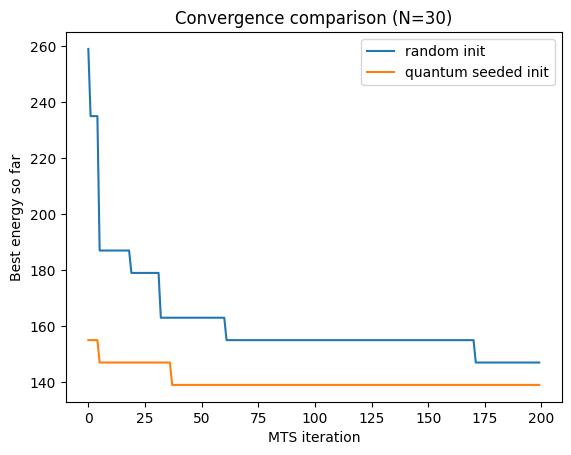

In [52]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(out_rand["history"], label="random init")
plt.plot(out_q["history"], label="quantum seeded init")
plt.xlabel("MTS iteration")
plt.ylabel("Best energy so far")
plt.title(f"Convergence comparison (N={N})")
plt.legend()
plt.show()